## Product Recommendation Based on Image Similarity

- Used a pre-trained CNN model from Keras to extract the image features. 
- Then computed similarities between the different products using the previously extracted image features.

 <img src="../reference/awswebsite.png" width=400 align="left">

### Import libraries

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFile
from keras.models import Model
from keras.applications import vgg16
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import load_img,img_to_array
from sklearn.metrics.pairwise import cosine_similarity

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.11 ms


### Set parameters

In [3]:
# Set variables.
imgs_path = "./10K_Shoes_images/"
imgs_model_width, imgs_model_height = 224, 224
num_closest_images = 5 # number of most similar product to retrieve

time: 1.03 ms


### Data Processing 

In [4]:
# Get all image files. 
image_files = [imgs_path + pic for pic in os.listdir(imgs_path) if "jpg" in pic]
print("Number of images:",len(image_files))

Number of images: 774
time: 12.4 ms


In [5]:
# Show images.
# original = load_img(image_files[10], target_size=(224,224))
# plt.imshow(original)
# plt.show()

time: 737 µs


In [6]:
# Get all product asins.
productIds = []
for file in image_files:
    base = os.path.basename(file)
    asin = os.path.splitext(base)[0]
    productIds.append(asin)
print("Number of productIds:",len(productIds))

Number of productIds: 774
time: 3.3 ms


In [7]:
# Get image urls and save as dictionary. {asin: image_url}
imgUrl_df = pd.read_csv('./asin_url_for_10k.csv')
imgUrl_dict = pd.Series(imgUrl_df.url.values,index=imgUrl_df.asin).to_dict()

time: 13.3 ms


### Load the VGG pre-trained model from Keras

Loaded the VGG16 model trained on imagenet, a big labeled images database. If we take the whole model, we will get an output containing probabilities to belong to certain classes,so removed the last layers of the CNN which are only used for classes predictions.


<img src="../reference/cnnLayers.png" width="400">

In [8]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

### Feed one image into CNN.

In [10]:
# convert the PIL image to a numpy array
# in PIL - image is in (width, height, channel)
# in Numpy - image is in (height, width, channel)
original = load_img(image_files[10], target_size=(224,224))
numpy_image = img_to_array(original)

# convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# we want the input matrix to the network to be of the form (batchsize, height, width, channels)
# thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('Image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

Image batch size (1, 224, 224, 3)
time: 41.1 ms


In [11]:
# get the extracted features
img_features = feat_extractor.predict(processed_image)

print("Features successfully extracted!")
print("Number of image features:",img_features.size)

Features successfully extracted!
Number of image features: 4096
time: 410 ms


### Feed all images into CNN

In [14]:
# load all the images and prepare them for feeding into the CNN
ImageFile.LOAD_TRUNCATED_IMAGES = True
importedImages = []

for file in image_files:
    filename = file
    original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

time: 7.62 s


### Extract the image fetures. (saved as csv file)

In [16]:
# Extract the images features.
imgs_features = feat_extractor.predict(processed_imgs)

print("Features successfully extracted!")
print("Size of feature dataset:", imgs_features.shape)

Features successfully extracted!
Size of feature dataset: (774, 4096)
time: 1.26 ms


In [17]:
# Convert to DataFrame.
features_df = pd.DataFrame(data=imgs_features, index=productIds, columns=range(4096))
features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
B00XB2Y4BA,2.579302,0.0,3.017223,0.000000,0.0,3.858268,0.000000,0.000000,0.0,1.010415,...,0.000000,0.0,0.0,0.000000,0.000000,1.510618,0.936177,4.268580,0.0,1.378045
B00318CFWE,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,5.981456,0.0,0.000000,...,0.791075,0.0,0.0,2.030918,0.000000,0.826475,0.000000,0.000000,0.0,0.000000
B00B5SCMMU,0.000000,0.0,0.000000,3.926949,0.0,0.000000,0.000000,1.650023,0.0,4.880582,...,0.000000,0.0,0.0,0.000000,0.450393,0.173273,0.000000,0.000000,0.0,0.000000
B00B7NVFF8,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,2.192223,...,0.000000,0.0,0.0,3.384481,0.000000,4.443202,0.000000,0.000000,0.0,0.000000
B00IA41NWM,0.000000,0.0,0.000000,0.000000,0.0,0.460994,0.079312,0.000000,0.0,4.405677,...,1.262090,0.0,0.0,1.275759,0.000000,3.837105,0.000000,1.871971,0.0,0.000000


time: 37.7 ms


In [18]:
# Save as a csv file.
features_df.to_csv('./features_10k.csv')

time: 2.61 s


### Compute cosine similarities.

In [19]:
# compute cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=productIds, index=productIds)
cos_similarities_df.head()

,B00XB2Y4BA,B00318CFWE,B00B5SCMMU,B00B7NVFF8,B00IA41NWM,B002OSXYP4,B00MZ2GLFO,B009CYNBRO,B002UXS2FA,B00B4NJ4O0,...,B00FPW9BFI,B0033PSJ9S,B00SGZW6ZI,B00DYRXKOO,B005BHOU3A,B008J27Y6Y,B00I5ILS2S,B005CMR08Q,B00B9TZTJ8,B000O8L0W0
B00XB2Y4BA,1.000000,0.530334,0.402511,0.431478,0.549208,0.514210,0.381826,0.661822,0.549727,0.520889,...,0.545874,0.435594,0.579932,0.333028,0.403758,0.459941,0.495702,0.460752,0.471728,0.254282
B00318CFWE,0.530334,1.000000,0.489754,0.520178,0.541808,0.514650,0.414598,0.610139,0.556360,0.554457,...,0.630413,0.524773,0.698462,0.475521,0.593337,0.590240,0.553078,0.576252,0.613987,0.261559
B00B5SCMMU,0.402511,0.489754,1.000000,0.425145,0.479248,0.428554,0.498948,0.504771,0.446560,0.474143,...,0.553902,0.551530,0.436136,0.468467,0.473856,0.565498,0.538658,0.597072,0.414588,0.225154
B00B7NVFF8,0.431478,0.520178,0.425145,1.000000,0.429695,0.641628,0.354639,0.409165,0.423424,0.536392,...,0.416270,0.467323,0.497083,0.604774,0.439174,0.470626,0.452611,0.374637,0.569250,0.223123
B00IA41NWM,0.549208,0.541808,0.479248,0.429695,1.000000,0.490630,0.337364,0.484252,0.493347,0.676791,...,0.651412,0.391423,0.513880,0.503156,0.449450,0.392316,0.613079,0.395010,0.525679,0.170339


time: 90.2 ms


### Retrieve the top 5 most similar products 

In [29]:
def retrieve_most_similar_products(given_img,num_closest_images):
    
    base=os.path.basename(given_img)
    asin = os.path.splitext(base)[0]

    print("-----------------------------------------------------------------------")
    print("original product:",asin)

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()
   
    
    
    
    print("-----------------------------------------------------------------------")
    print("most similar products:")
    
    base = os.path.basename(given_img)
    given_asin = os.path.splitext(base)[0]
    
    closest_imgs = cos_similarities_df[given_asin].sort_values(ascending=False)[1:num_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_asin].sort_values(ascending=False)[1:num_closest_images+1]

    for i in range(0,len(closest_imgs)):
        asin = closest_imgs[i]
        dir_name = './10K_Shoes_images/'
        file_path = os.path.join(dir_name, asin + ".jpg" )
        original = load_img(file_path, target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()

        print("product ID:",asin)
        print("similarity score : ",closest_imgs_scores[i])

time: 4.17 ms


-----------------------------------------------------------------------
original product: B00KWK3UD2


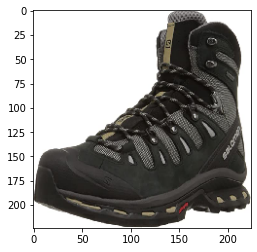

-----------------------------------------------------------------------
most similar products:


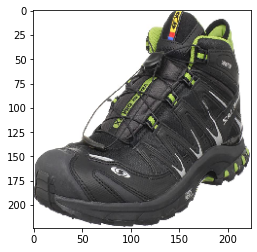

product ID: B0033PSJ9S
similarity score :  0.8294498


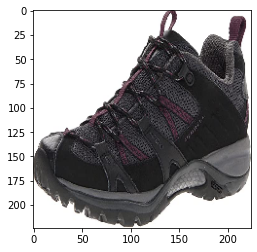

product ID: B008J4RXDG
similarity score :  0.8290274


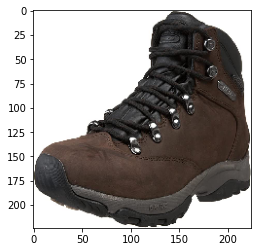

product ID: B0036VNRL4
similarity score :  0.8253776


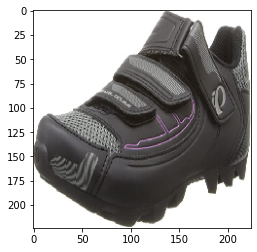

product ID: B00M03TI3U
similarity score :  0.8227667


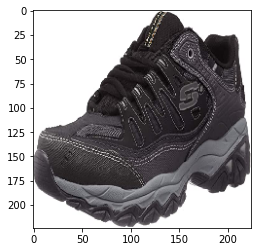

product ID: B00D881ERE
similarity score :  0.8197336
time: 945 ms


In [30]:
retrieve_most_similar_products(given_img=image_files[40], num_closest_images=5)

### Retrieve the top 5 most similar products for all products.(saved as csv file)

In [31]:
# Create an emply dataframe with given column names.
column_names = ["given_product", "given_product_img_url", \
                "recommended_product", "recommended_product_img_url",\
                "similarity_score"]

recommeded_df = pd.DataFrame(columns = column_names)

time: 4.32 ms


In [33]:
for product in productIds:
    closest_imgs_scores = cos_similarities_df[product].sort_values(ascending=False)[1:num_closest_images+1]
    asins = list(closest_imgs_scores.index)
    scores = list(closest_imgs_scores.values)
    for i in range(num_closest_images):
        new_row = {"given_product":product, "given_product_img_url": imgUrl_dict[product],\
                   "recommended_product": asins[i], "recommended_product_img_url": imgUrl_dict[asins[i]],\
                   "similarity_score": scores[i]}
        recommeded_df = recommeded_df.append(new_row, ignore_index=True)

time: 8.4 s


In [34]:
recommeded_df.head()

,given_product,given_product_img_url,recommended_product,recommended_product_img_url,similarity_score
0,B00XB2Y4BA,https://images-na.ssl-images-amazon.com/images...,B008E16XHQ,https://images-na.ssl-images-amazon.com/images...,0.764636
1,B00XB2Y4BA,https://images-na.ssl-images-amazon.com/images...,B00WY9K7LC,https://images-na.ssl-images-amazon.com/images...,0.729277
2,B00XB2Y4BA,https://images-na.ssl-images-amazon.com/images...,B009AMVXMI,https://images-na.ssl-images-amazon.com/images...,0.711026
3,B00XB2Y4BA,https://images-na.ssl-images-amazon.com/images...,B002SG8EAW,https://images-na.ssl-images-amazon.com/images...,0.709472
4,B00XB2Y4BA,https://images-na.ssl-images-amazon.com/images...,B005ES60ZM,https://images-na.ssl-images-amazon.com/images...,0.699484


time: 8.7 ms


In [35]:
# Save as a csv file.
recommeded_df.to_csv('./image_recommended_product_10k.csv',index=False)

time: 39.5 ms
